<a href="https://colab.research.google.com/github/jonas293/Test/blob/master/ScaleLSTM2Inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [32]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [33]:
!nvidia-smi

Thu Mar 28 09:05:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |    344MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [34]:
!pip install keras

In [0]:
from keras import backend as K

if 'tensorflow' == K.backend():
  import tensorflow as tf
  from keras.backend.tensorflow_backend import set_session
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  config.gpu_options.visible_device_list = "0"
  set_session(tf.Session(config=config))

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [37]:
import os

# choose a local (colab) directory to store the data.
local_root_path = os.path.expanduser("~/Colab")
try:
  os.makedirs(local_root_path)
except: pass

def ListFolder(google_drive_id, destination):
  file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % google_drive_id}).GetList()
  counter = 0
  for f in file_list:
    # If it is a directory then, create the dicrectory and upload the file inside it
    if f['mimeType']=='application/vnd.google-apps.folder': 
      folder_path = os.path.join(destination, f['title'])
      os.makedirs(folder_path)
      print('creating directory {}'.format(folder_path))
      ListFolder(f['id'], folder_path)
    else:
      fname = os.path.join(destination, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)
      counter += 1
  print('{} files were uploaded in {}'.format(counter, destination))

ListFolder("18cS38DYpGCfHnG3MKjmnjN4NUBSIEFpl", local_root_path)

18 files were uploaded in /root/Colab


In [38]:
!ls ~/Colab

 1LayerLSTM.hdf5		      Sp500Close.csv
 1ScaleLayerLSTMEpoch380-00021.hdf5   SP500CloseLong.csv
 1ScaleLayerLSTMEpoch380.hdf5	      Sp500Complete63.csv
 1ScaleLayerLSTM.hdf5		      TSLAClose.csv
 2LayerLSTM.hdf5		      Tweepy.ipynb
'First LSTM NN-1Inputs.ipynb'	      TwitterSP500Close_19.3.csv
'First LSTM NN-2Inputs.ipynb'	      TwitterSP500Close_28.3.csv
'Scale First LSTM NN-1Inputs.ipynb'   TwitterSP500Close.csv
 ScaleLSTM2Inputs.ipynb		     'Yahoo API.ipynb'


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv(os.path.expanduser("~/Colab/TwitterSP500Close_28.3.csv"))
df = df.drop("Unnamed: 0", axis=1)
df = df.drop("Sentiment", axis=1)
df = df.rename(columns = {"New Sentiment":"Sentiment"})
df = df.iloc[::-1]
df = df.reset_index()
df = df.drop ("index", axis=1)
df.head()

,Date,Tweet,Sentiment,Close
0,2019-03-27,b'RT @zeroleverage: Sell off comes overnight a...,0.035874,2805.370117
1,2019-03-26,b'RT @SenseiHov: Alright guys\n\nToday I trade...,0.037667,2818.459961
2,2019-03-25,b'#USDJPY -&gt; Technicals + Intermarket play ...,0.018866,2798.360107
3,2019-03-22,b'SP daily parabolas 03/22/2019 #SP500\xc2\xa0...,0.016319,2800.709961
4,2019-03-21,b'The #SP500 is just 5.7% from reaching all ti...,0.081840,2854.879883


# Data overview

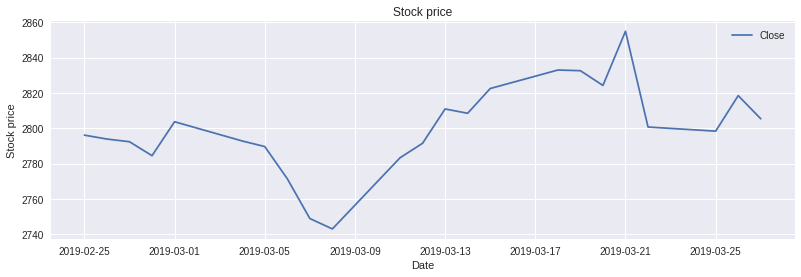

In [40]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

#years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator()  # every month
#yearsFmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=plt.figaspect(0.3))
fig.add_axes()
ax = fig.add_subplot(111)

# format the ticks
#ax = plt.gca()
#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(yearsFmt)
#ax.xaxis.set_minor_locator(months)

dates = np.array(df["Date"]).astype(np.datetime64)


x = dates
y = df["Close"]

plt.plot(x,y)
#ax.set(ylim = [,])
ax.set(title = "Stock price",
      ylabel = "Stock price",
      xlabel = "Date")
ax.legend(loc = "best")

#Hier zweiten Graph einfügen mit 

# Prepare data / Calculate %-changes

In [41]:
df["Close_before"] = df["Close"].shift(-1)
df["Sentiment_before"] = df["Sentiment"].shift(-1)
df = df[["Date","Tweet","Sentiment", "Sentiment_before", "Close", "Close_before"]]
df = df.dropna()
df

,Date,Tweet,Sentiment,Sentiment_before,Close,Close_before
0,2019-03-27,b'RT @zeroleverage: Sell off comes overnight a...,0.035874,0.037667,2805.370117,2818.459961
1,2019-03-26,b'RT @SenseiHov: Alright guys\n\nToday I trade...,0.037667,0.018866,2818.459961,2798.360107
2,2019-03-25,b'#USDJPY -&gt; Technicals + Intermarket play ...,0.018866,0.016319,2798.360107,2800.709961
3,2019-03-22,b'SP daily parabolas 03/22/2019 #SP500\xc2\xa0...,0.016319,0.081840,2800.709961,2854.879883
4,2019-03-21,b'The #SP500 is just 5.7% from reaching all ti...,0.081840,0.059207,2854.879883,2824.229980
5,2019-03-20,b'VIDEO: No Fed Hike - Stock Price Fake Out?\n...,0.059207,0.100727,2824.229980,2832.570068
6,2019-03-19,b'RT @TimmerFidelity: Ten years after the bull...,0.100727,0.100385,2832.570068,2832.939941
7,2019-03-18,b'The C Fund Reached 2019 Highs\n\nhttps://t.c...,0.100385,0.102757,2832.939941,2822.479980
8,2019-03-15,b'RetFXPro Hears: S&amp;P500 Technical Analysi...,0.102757,0.053675,2822.479980,2808.479980
9,2019-03-14,b'RT @TimmerFidelity: Ten years after the bull...,0.053675,0.065440,2808.479980,2810.919922


In [42]:
### Daten werden Normalisiert ###

from pandas import Series
from sklearn.preprocessing import MinMaxScaler


series1 = Series(df["Close"])
series2 = Series(df["Sentiment"])

# prepare data for normalization
values1 = series1.values
values1 = values1.reshape((len(values1), 1))
values2 = series2.values
values2 = values2.reshape((len(values2), 1))

# train the normalization
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1 = scaler1.fit(values1)
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2 = scaler2.fit(values2)
print('Min: %f, Max: %f' % (scaler2.data_min_, scaler2.data_max_))

# normalize the dataset and print
normalized1 = scaler1.transform(values1)
df["Normalized_Data_Close"] = normalized1
normalized2 = scaler2.transform(values2)
df["Normalized_Data_Sentiment"] = normalized2
print(normalized2)

#inverse transform and print
#inversed = scaler.inverse_transform(normalized)
#print(inversed)

closesnorm1 = df["Normalized_Data_Close"]
#closesnorm1.plot()
closesnorm2 = df["Normalized_Data_Sentiment"]
#closesnorm2.plot()

Min: 0.016319, Max: 0.126660
[[0.17722556]
 [0.19347772]
 [0.02308672]
 [0.        ]
 [0.59380515]
 [0.3886845 ]
 [0.76497048]
 [0.76187335]
 [0.78336877]
 [0.33854938]
 [0.4451708 ]
 [0.54493639]
 [0.47657219]
 [0.43813991]
 [0.3778329 ]
 [0.27456941]
 [0.34753226]
 [0.6402196 ]
 [1.        ]
 [0.29836531]
 [0.13836965]
 [0.03684186]]


In [43]:
normalizeddata = df[["Normalized_Data_Close","Normalized_Data_Sentiment"]].values
normalizeddata 

array([[0.5571966 , 0.17722556],
       [0.67426901, 0.19347772],
       [0.49450077, 0.02308672],
       [0.51551729, 0.        ],
       [1.        , 0.59380515],
       [0.72587467, 0.3886845 ],
       [0.8004664 , 0.76497048],
       [0.80377446, 0.76187335],
       [0.71022309, 0.78336877],
       [0.58501047, 0.33854938],
       [0.60683272, 0.4451708 ],
       [0.43332467, 0.54493639],
       [0.35980724, 0.47657219],
       [0.        , 0.43813991],
       [0.0524092 , 0.3778329 ],
       [0.25382282, 0.27456941],
       [0.4165988 , 0.34753226],
       [0.44486247, 0.6402196 ],
       [0.54216952, 1.        ],
       [0.37044979, 0.29836531],
       [0.44101508, 0.13836965],
       [0.45460977, 0.03684186]])

# Divide into Train-/Test Data

In [44]:
### Könnte es hier noch versuchen im LSTM Model mit mehr/weniger als den letzten 20 Tagen zu rechnen! ###

X_train = []
y_train = []
for i in range (3, len(normalizeddata) - 3):
    y_train.append(normalizeddata[i,0])
    X_train.append(np.array((normalizeddata[i+1:i+4][::-1])))

X_train = np.array(X_train).reshape(-1,3,2)
y_train = np.array(y_train)

X_test = []
y_test = []
for i in range (0,3):
    y_test.append(normalizeddata[i,0])
    X_test.append(np.array((normalizeddata[i+1:i+4][::-1])))

X_test = np.array(X_test).reshape(-1,3,2)
y_test = np.array(y_test)

y_train.shape

(16,)

# Build model

In [0]:
from keras.layers.core import Activation, Dropout, Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import regularizers

#model = Sequential()
#Kernel regularizer soll angeblich besser funktionieren als Dropout layer um Overfitting zu vermeiden (da sich das Modell sonst zu sehr an Daten erinnert!
#model.add(LSTM(100,activation="tanh", return_sequences=True,input_shape = (3, 2),kernel_regularizer= regularizers.l2(0.01)))
#model.add(LSTM(50,activation="tanh", return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(1,activation ="tanh"))
#model.add(Activation("linear"))

model = Sequential()

model.add(LSTM(1,activation="relu", input_shape = (3, 2)))
#model.add(LSTM(50,activation="tanh", return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(1,activation ="tanh"))
#model.add(Activation("linear"))

model.compile(optimizer="adam", loss="mse")

# Train model

In [46]:
model.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
16/16 [==============================] - 1s 34ms/step - loss: 0.3095
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3086
Epoch 3/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3076
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3066
Epoch 5/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3054
Epoch 6/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3045
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3033
Epoch 8/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3022
Epoch 9/100
16/16 [==============================] - 0s 1ms/step - loss: 0.3010
Epoch 10/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2999
Epoch 11/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2988
Epoch 12/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2975
Epoch 13/100
16/16 [================

# Import model if needed

In [0]:
#from keras.models import load_model
#model = load_model('1LayerLSTM.hdf5')

# Evaluate predictions + use

In [48]:
model.predict(X_train)

array([[0.7825348 ],
       [0.6115483 ],
       [0.5621635 ],
       [0.5707313 ],
       [0.534925  ],
       [0.45493826],
       [0.36916995],
       [0.1914453 ],
       [0.10640403],
       [0.07598403],
       [0.17753215],
       [0.2630952 ],
       [0.2459665 ],
       [0.24873394],
       [0.33948943],
       [0.42618436]], dtype=float32)

# Predict for X_train

In [49]:
y_predtrain = model.predict(X_train)
y_predtrain = y_predtrain.reshape(-1)
y_predtrain.shape

(16,)

In [50]:
df_predtrain = df[3:-3]
df_predtrain["Close_predicted_train"] =  scaler1.inverse_transform(y_predtrain.reshape(-1, 1))
df_predtrain.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(16, 9)

# Predict for X_test

In [51]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_pred.shape

(3,)

In [52]:
df_pred = df[:3]
df_pred["Close_predicted_test"] = scaler1.inverse_transform(y_pred.reshape(-1, 1))
df_pred.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(3, 9)

In [53]:
df_pred['Buy/Sell'] = np.where(df_pred["Close_before"] <= df_pred["Close"], 'Buy', 'Sell')

df_pred['Buy/Sell_pred'] = np.where(df_pred["Close_before"] <= df_pred["Close_predicted_test"], 'Buy', 'Sell')

df_pred = df_pred[["Date","Close", "Close_before","Close_predicted_test","Buy/Sell","Buy/Sell_pred"]]

df_pred_calc = df_pred.iloc[::-1]
df_pred_calc = df_pred_calc.reset_index()
df_pred_calc = df_pred_calc.drop ("index", axis=1)
df_pred_calc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Close,Close_before,Close_predicted_test,Buy/Sell,Buy/Sell_pred
0,2019-03-25,2798.360107,2800.709961,2816.581543,Sell,Buy
1,2019-03-26,2818.459961,2798.360107,2810.922852,Buy,Buy
2,2019-03-27,2805.370117,2818.459961,2814.355713,Sell,Sell


In [54]:
Cash = 10000
count = 0
NoStock = 0

for i in df_pred_calc["Close_before"]:
  if df_pred_calc["Buy/Sell_pred"][count]=="Buy":
    Cash = Cash - i * 1
    NoStock = NoStock + 1
  else:
    if NoStock > 0:
      Cash = Cash + i * 1 
      NoStock = NoStock - 1
    else: 
      Cash = Cash
      NoStock = NoStock
  
  count = count + 1
  
print("Cash after trading: " + str(Cash + (NoStock * df_pred_calc["Close"][len(df_pred_calc)-1])))
print("Stocks end of period: " + str(NoStock))

Cash after trading: 10024.760009765625
Stocks end of period: 1


## Training Dataframe

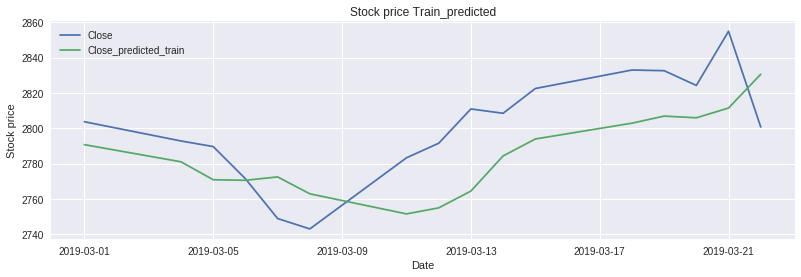

In [55]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# Sorgt dafür das lediglich Jahreszahlen angezeigt werden wenn gewünscht
#ax = plt.gca() -> Nur verwenden wenn plotten über plt Methode
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

dates1 = np.array(df_predtrain["Date"]).astype(np.datetime64)

x = dates1
y1 = df_predtrain["Close"]
y2 = df_predtrain["Close_predicted_train"]


fig1 = plt.figure(figsize=plt.figaspect(0.3))
fig1.add_axes()

ax1 = fig1.add_subplot(111)
ax1.plot(x,y1)
ax1.plot(x,y2)
ax1.set(title = "Stock price Train_predicted",
      ylabel = "Stock price",
      xlabel = "Date")
ax1.legend(loc = "best")

ax1.legend()

plt.show()

In [56]:
import sklearn.metrics, math

print("R square: %f" % sklearn.metrics.r2_score(df_predtrain["Close"],df_predtrain["Close_predicted_train"]))

R square: 0.105593


## Test DF

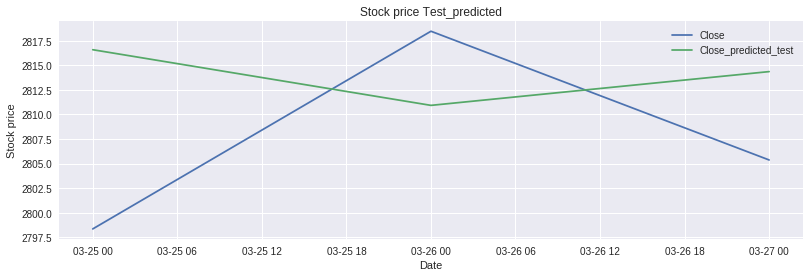

In [57]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# Sorgt dafür das lediglich Jahreszahlen angezeigt werden wenn gewünscht
#ax = plt.gca() -> Nur verwenden wenn plotten über plt Methode
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

dates2 = np.array(df_pred["Date"]).astype(np.datetime64)

x1 = dates2
y3 = df_pred["Close"]
y4 = df_pred["Close_predicted_test"]


fig1 = plt.figure(figsize=plt.figaspect(0.3))
fig1.add_axes()

ax1 = fig1.add_subplot(111)
ax1.plot(x1,y3)
ax1.plot(x1,y4)
ax1.set(title = "Stock price Test_predicted",
      ylabel = "Stock price",
      xlabel = "Date")
ax1.legend(loc = "best")

ax1.legend()

plt.show()

In [58]:
print("R square: %f" % sklearn.metrics.r2_score(df_pred["Close"],df_pred["Close_predicted_test"]))

R square: -1.255781


In [0]:
### 1. Schauen wie das Modell mit anderen Daten (bspw. TSLA performt) ###

### Nun andere Modelle mit diesen Train/Test Daten trainieren und dann anhand MSE & R^2 miteinander vergleichen ###